In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow_tts.inference import AutoConfig
from tensorflow_tts.inference import TFAutoModel
from tensorflow_tts.inference import AutoProcessor

import numpy as np
from sklearn.preprocessing import StandardScaler
import librosa

import IPython.display as ipd

In [2]:
import os
os.getcwd()

'/home/rodrigo-kobashikawa/TensorFlowTTS/notebooks'

In [3]:
processor = AutoProcessor.from_pretrained("../dump_commonvoicebr_16/commonvoicebr_mapper.json")

In [4]:
input_text = "eu te amo."
input_ids = processor.text_to_sequence(input_text)

In [5]:
input_ids

[60, 82, 12, 81, 60, 12, 51, 71, 73, 8, 90]

In [6]:
config = AutoConfig.from_pretrained("../ttsexamples/tacotron2/conf/tacotron2.v1.yaml")
tacotron2 = TFAutoModel.from_pretrained(
    config=config, 
    pretrained_path="../ttsexamples/tacotron2/exp/train.tacotron2_finetune_16_r_1_wo_mx.v1/checkpoints/model-20000.h5",
    is_build=True, # don't build model if you want to save it to pb. (TF related bug)
    name="tacotron2"
)

In [7]:
tacotron2.setup_window(win_front=6, win_back=6)
tacotron2.setup_maximum_iterations(3000)

# Save to Pb

In [ ]:
decoder_output, mel_outputs, stop_token_prediction, alignment_history = tacotron2.inference(
        input_ids=tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        input_lengths=tf.convert_to_tensor([len(input_ids)], tf.int32),
        speaker_ids=tf.convert_to_tensor([0], dtype=tf.int32),
)

In [ ]:
tacotron2.load_weights("../ttsexamples/tacotron2/exp/train.tacotron2_16_mx_PCM16.v1/checkpoints/model-73224.h5")

In [11]:
# save model into pb and do inference. Note that signatures should be a tf.function with input_signatures.
tf.saved_model.save(tacotron2, "./test_saved", signatures=tacotron2.inference)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./test_saved/assets


# Load and Inference

In [12]:
tacotron2 = tf.saved_model.load("./test_saved")

In [28]:
# "Este é meu trabalho de conclusão do curso."
# "Bem vindos a apresentação do meu trabalho de conclusão do curso"
# "Meu nome é rodrigo"
# "Muito obrigado e até mais"


input_text = "O rato roeu a roupa do rei de roma"
input_ids = processor.text_to_sequence(input_text)

In [29]:
decoder_output, mel_outputs, stop_token_prediction, alignment_history = tacotron2.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        tf.convert_to_tensor([len(input_ids)], tf.int32),
        tf.convert_to_tensor([0], dtype=tf.int32)
)

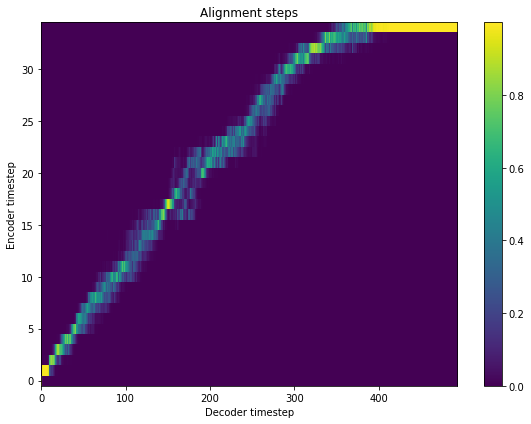

In [30]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title(f'Alignment steps')
im = ax.imshow(
    alignment_history[0].numpy(),
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()
plt.close()

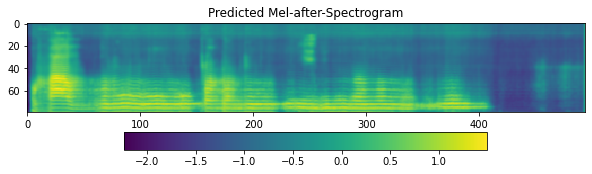

In [31]:
mel_outputs = tf.reshape(mel_outputs, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()

In [32]:
scaler = StandardScaler()

In [33]:
scaler.mean_, scaler.scale_ = np.load('../dump_commonvoicebr_16/stats.npy')
scaler.n_features_in_ = 80

In [34]:
mel_spec = np.power(10.0, scaler.inverse_transform(mel_outputs)).T

In [35]:
mel_basis = librosa.filters.mel(22050,
        n_fft=1024,
        n_mels=80,
        fmin=80,
        fmax=7600,
    )
mel_to_linear = np.maximum(1e-10, np.dot(np.linalg.pinv(mel_basis), mel_spec))
gl_lb = librosa.griffinlim(
    mel_to_linear,
    n_iter=32,
    hop_length=256,
    win_length=None or 1024,
)

In [36]:
sr=22050

In [37]:
ipd.Audio(gl_lb, rate=sr)

# Let inference other input to check dynamic shape

In [17]:
input_text = "The Commission further recommends that the Secret Service coordinate its planning as closely as possible with all of the Federal agencies from which it receives information."
input_ids = processor.text_to_sequence(input_text)

In [18]:
decoder_output, mel_outputs, stop_token_prediction, alignment_history = tacotron2.inference(
        tf.expand_dims(tf.convert_to_tensor(input_ids, dtype=tf.int32), 0),
        tf.convert_to_tensor([len(input_ids)], tf.int32),
        tf.convert_to_tensor([0], dtype=tf.int32),
)

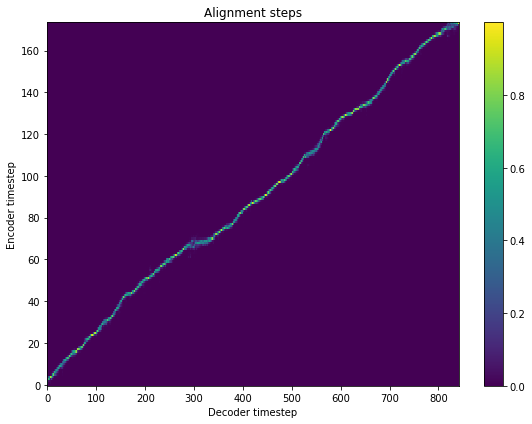

In [19]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title(f'Alignment steps')
im = ax.imshow(
    alignment_history[0].numpy(),
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()
plt.close()

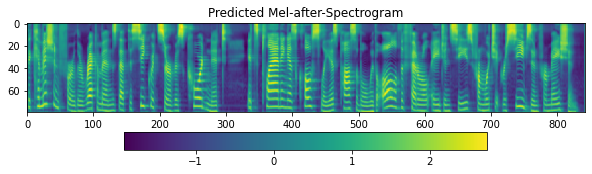

In [20]:
mel_outputs = tf.reshape(mel_outputs, [-1, 80]).numpy()
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-after-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()
plt.close()